# IoT Assignment (Machine Learning Portion)

## Done By: Lee Yong Zhang 1828302 DISM/FT/3A/32 Group 2

### Data Importing

In [128]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from operator import itemgetter
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

#### For this part of the code, I decided to combine all 10 of the feature files into one so that it looks neater without 10 rows of reading files

In [129]:
#extension = "csv"
#os.chdir("./Features")
#all_filenames = [i for i in glob.glob("*.{}".format(extension))]
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
#combined_csv.to_csv("combined_csv.csv", index=False, encoding="utf-8-sig")
#os.chdir("../")

### Data Exploration and Cleaning

In [130]:
# This part reads the features file and the labels file and shows some basic data about them

data = pd.read_csv("./Features/combined_csv.csv")
label = pd.read_csv("./Labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")
len(data.index)
print(data.shape)
print(label.shape)
data.head(5)

(16135561, 11)
(20018, 2)


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


In [131]:
# Checking for duplicates in the labels file 
label.loc[label.bookingID.duplicated()]

,bookingID,label
5295,154618822837,0
6210,1279900254294,0
6516,1511828488211,0
10778,455266533495,0
11215,223338299461,1
12602,13,1
13634,970662608932,1
14432,1632087572573,0
14942,1391569403991,1
16340,1408749273124,1


In [132]:
# Remove the duplicates to stop any errors
label.drop_duplicates(subset="bookingID", keep="last", inplace=True)

In [133]:
# Checking for any missing values to clean
print("Blank rows in features: ",data.isnull().values.any())
print("Blank rows in labels: ",label.isnull().values.any())

Blank rows in features:  False
Blank rows in labels:  False


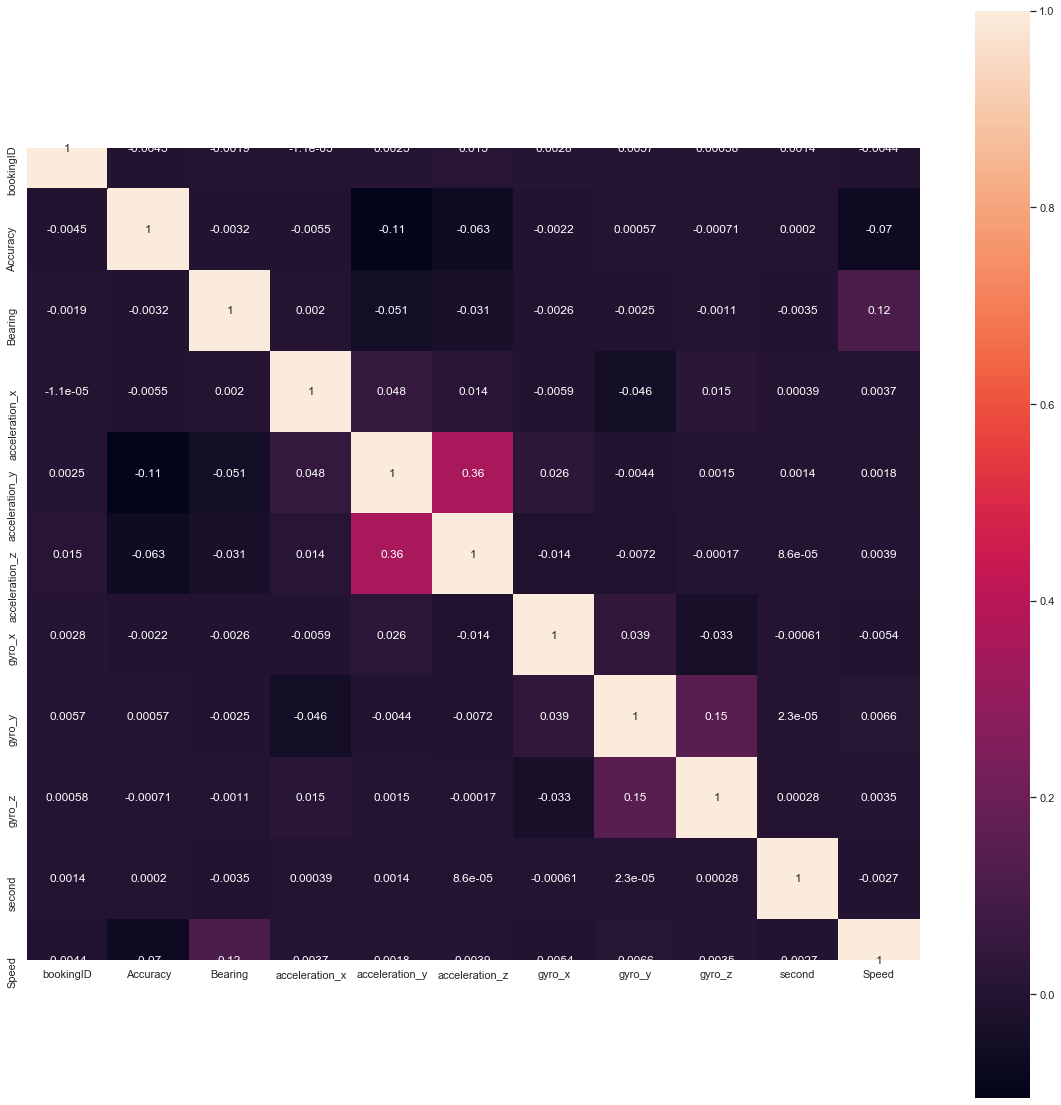

In [134]:
# Show the correlation matrix to show the relationships between the different features

cormat = data.corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(cormat,square=True,annot=True)

#### This is the place where I do most of the data exploration. 

#### From the boxplots, we can see that second feature has many outliers which can affect the accuracy of the prediction. With a delay of over 2hrs between telemetric value entries, it shows that those values may not be valid

#### This is the same for the accuracy feature, where it has been explained to be in meters but many rows are about thousands of meters accurate. This means some of the telemetrics entries are not accurately captured from the driver due to issues with the gps.

Boxplot of:  bookingID


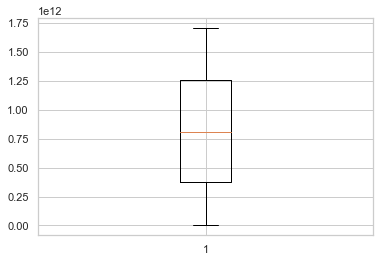

Boxplot of:  Accuracy


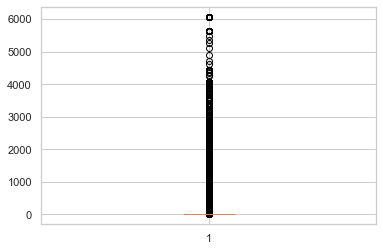

Boxplot of:  Bearing


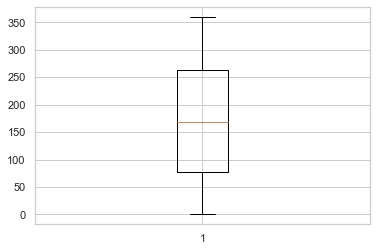

Boxplot of:  acceleration_x


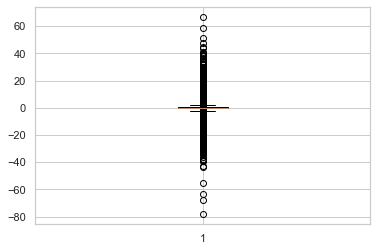

Boxplot of:  acceleration_y


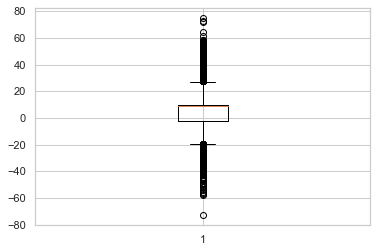

Boxplot of:  acceleration_z


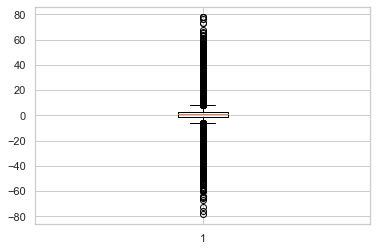

Boxplot of:  gyro_x


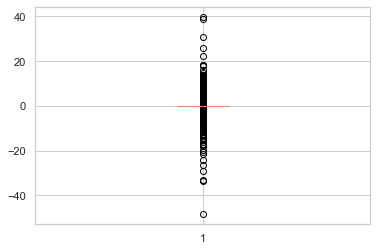

Boxplot of:  gyro_y


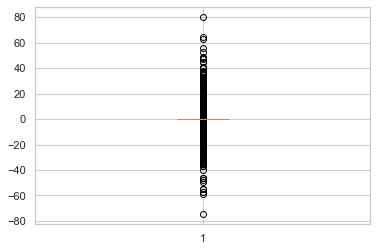

Boxplot of:  gyro_z


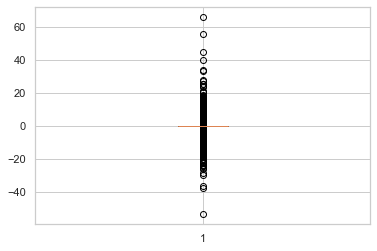

Boxplot of:  second


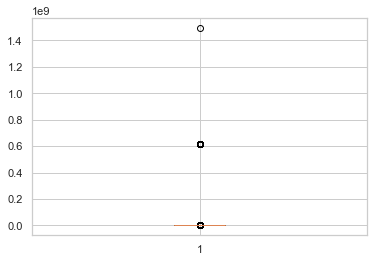

Boxplot of:  Speed


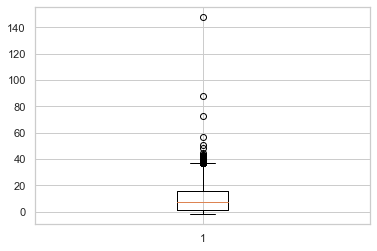

In [135]:
# Showing boxplots of all the features for visualisation

for col in data.columns:
    print("Boxplot of: ",col)
    plt.boxplot(data[col])
    plt.show()

#### Since the accuracy is in meters, I feel that having a discreptancy of 10 meters is the max we should allow before dropping the rest. For seconds, values over 2000 seconds should be a good seperator for time between each telemetric values submitted

In [136]:
# Dropping the unwanted values

data.drop(data.loc[data["second"] > 2000].index, inplace=True)
data.drop(data.loc[data["Accuracy"] > 10.0].index, inplace=True)

### Feature Engineering

#### This part of the feature engineering aims to generate more columns to help improve the models accuracy.

In [137]:
# Distance
# Reasoning: Maybe drive too long the driver will become careless and drive dangerously

data["distance"] = data["Speed"] * data["second"]

# Resultant Acceleration
# Reasoning: Calculating the resultant acceleration allows the ai to know the exact amount 
#            of acceleration for the row instead of trying to figure out using points on a 3d axis

data["acceleration"] = np.sqrt((data["acceleration_x"]**2) + (data["acceleration_y"]**2) + (data["acceleration_z"]**2))
data['acc_xy']=np.sqrt(data['acceleration_x']**2+data['acceleration_y']**2)
data['acc_xz']=np.sqrt(data['acceleration_x']**2+data['acceleration_z']**2)
data['acc_yz']=np.sqrt(data['acceleration_z']**2+data['acceleration_y']**2)

# Gyroscope Interactions
# Reasoning: Interactions of gyroscope values will allow the model to calculate the turns to see if they are jarring
#            which might be an indicator of driving dangerously

data['rad_x']=data['gyro_x']*data['second']
data['rad_y']=data['gyro_y']*data['second']
data['rad_z']=data['gyro_z']*data['second']
data['rad_xy']=np.sqrt(data['rad_x']**2+data['rad_y']**2)
data['rad_xz']=np.sqrt(data['rad_x']**2+data['rad_z']**2)
data['rad_yz']=np.sqrt(data['rad_z']**2+data['rad_y']**2)
data['rad_xyz']=np.sqrt(data['rad_x']**2+data['rad_y']**2+data['rad_z']**2)

data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,...,acc_xy,acc_xz,acc_yz,rad_x,rad_y,rad_z,rad_xy,rad_xz,rad_yz,rad_xyz
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,...,8.984536,4.172053,9.752317,11.196321,3.090280,-13.573460,11.614966,17.595353,13.920800,17.864665
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,...,8.659995,4.737413,9.870990,6.329731,1.035167,-2.790537,6.413818,6.917556,2.976352,6.994581
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,...,9.613765,2.259771,9.743373,-6.712836,-14.673258,1.091267,16.135882,6.800958,14.713782,16.172741
3,1073741824054,3.900,126.0,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,...,11.084467,3.873947,10.387261,1.212201,-306.320436,-16.196659,306.322834,16.241958,306.748335,306.750730
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,...,10.551564,1.564188,10.665679,107.065834,-50.591860,132.454789,118.417182,170.315483,141.787895,177.670763


In [138]:
# Generating more columns other than average for each of the rides for the merging with the labels

newdata = pd.DataFrame()
for col in data.columns:
    if col != "bookingID":
        temp = data.groupby("bookingID")[col].agg(["mean", "median", "max", "min"])
        newdata[col + "_mean"] = temp["mean"]
        newdata[col + "_median"] = temp["median"]
        newdata[col + "_max"] = temp["max"]
        newdata[col + "_min"] = temp["min"]

In [139]:
# This feature only has 0 and is not useful

newdata.drop(['second_min'], axis=1, inplace=True)

In [140]:
# Merging the features dataframe and the labels dataframe for fitting

ndata = pd.merge(newdata, label, on="bookingID")
ndata.shape
ndata.head(5)

,bookingID,Accuracy_mean,Accuracy_median,Accuracy_max,Accuracy_min,Bearing_mean,Bearing_median,Bearing_max,Bearing_min,acceleration_x_mean,...,rad_xz_min,rad_yz_mean,rad_yz_median,rad_yz_max,rad_yz_min,rad_xyz_mean,rad_xyz_median,rad_xyz_max,rad_xyz_min,label
0,0,7.696697,8.000,8.000,4.0,171.173919,143.298294,359.979767,0.037464,-0.709662,...,0.063897,102.126696,78.494387,758.206423,0.014358,126.503151,105.993472,771.558945,0.092563,0
1,1,3.718763,3.900,7.709,3.0,124.198590,110.000000,337.000000,0.000000,-0.525406,...,0.000000,35.132192,19.062919,379.064243,0.000000,38.658708,22.983215,382.674249,0.000000,1
2,2,3.930626,3.634,8.000,3.0,173.794872,233.000000,354.000000,1.000000,0.306786,...,0.000000,30.159647,7.365436,361.809305,0.000000,34.009188,9.342981,363.065743,0.000000,1
3,4,10.000000,10.000,10.000,10.0,151.807013,134.210114,353.855377,2.271227,-0.365117,...,0.000000,58.095621,34.951695,507.727800,0.000000,64.083755,41.190847,507.783749,0.000000,1
4,6,4.540712,4.000,8.000,3.0,197.678309,255.000000,359.000000,0.000000,0.495646,...,0.000000,43.714160,14.698702,671.967832,0.000000,53.598648,23.713419,676.573837,0.000000,0


### Model Fitting

In [141]:
# I choose the following models either because I have used them before during the AI elective or I find 
# might be useful for this assignment.

models_used = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
}

DecisionTreeRegressor
[0.02217309 0.00844994 0.00670515 0.00457316 0.0129425  0.0133844
 0.01045173 0.00866416 0.01163253 0.01334248 0.01553956 0.01680016
 0.00833943 0.00759433 0.01003531 0.00946763 0.00640848 0.00619978
 0.00818203 0.00943588 0.00609765 0.00553238 0.01154238 0.01300442
 0.01021733 0.01168915 0.01418534 0.01251827 0.01460039 0.01165059
 0.00839422 0.01034199 0.0762525  0.0220707  0.04382838 0.01917885
 0.01974853 0.02924195 0.00377953 0.0123601  0.01654401 0.01987722
 0.00842958 0.01011204 0.01076473 0.01320154 0.02082766 0.00685921
 0.00484304 0.01131261 0.0111482  0.00592751 0.00889395 0.0133686
 0.00955702 0.00818046 0.0077689  0.00624442 0.00830817 0.01051502
 0.00913909 0.00871101 0.00743782 0.01356912 0.00998366 0.0091186
 0.00813404 0.00922464 0.00981915 0.01732557 0.00667529 0.00754746
 0.00847837 0.01031523 0.00368028 0.01353755 0.01140602 0.01358087
 0.00169232 0.0040045  0.01097728 0.0078936  0.00116466 0.00495949
 0.00730955 0.00370077 0.00137381]


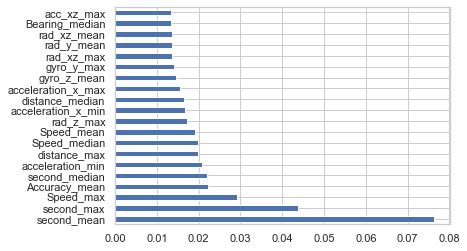

C:\Users\lyz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor
[0.0105726  0.00823553 0.00777835 0.00327875 0.01338302 0.01376954
 0.0123879  0.00723248 0.01071046 0.0127846  0.01538263 0.01575908
 0.00905542 0.00795034 0.01016873 0.01470846 0.00629494 0.00705175
 0.01313823 0.01185075 0.00886156 0.00880869 0.00930659 0.01292719
 0.0116334  0.00852539 0.01151356 0.0123703  0.01065587 0.00827529
 0.00991143 0.01225835 0.05636417 0.03749148 0.04236557 0.01927696
 0.0226361  0.02388468 0.00477182 0.01397253 0.01863924 0.0170954
 0.00883452 0.01030695 0.00976817 0.00772048 0.01207589 0.00792035
 0.00510303 0.01122876 0.01139057 0.00565226 0.00646639 0.01232454
 0.01365585 0.00713509 0.00847597 0.01087561 0.01021496 0.00953262
 0.00861331 0.01321985 0.01178955 0.01399099 0.01039436 0.01265067
 0.01225385 0.01163386 0.010233   0.01226659 0.0095408  0.00492387
 0.00783523 0.00629265 0.00199862 0.01901266 0.00984797 0.01171621
 0.00181388 0.00813051 0.0077071  0.01182481 0.00216906 0.00567385
 0.00477357 0.00638366 0.0015884 ]


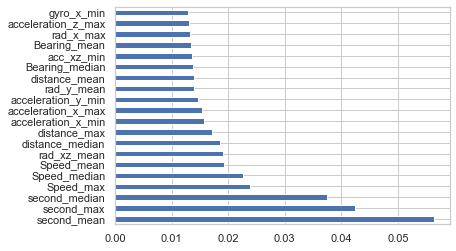

GradientBoostingRegressor
[1.69633826e-03 1.99484405e-02 4.40914534e-03 2.24935071e-03
 3.09084479e-03 5.40680009e-04 5.78279098e-03 3.50230918e-03
 4.19770945e-03 1.62242297e-03 6.13885859e-03 9.54520166e-03
 2.05033625e-03 6.04627957e-03 6.52055268e-03 1.08057238e-02
 9.34006092e-04 2.85445986e-03 6.39374801e-03 4.06883622e-03
 6.20020168e-05 1.28583116e-03 4.43950707e-04 1.66218506e-03
 4.05297408e-03 1.24598281e-04 2.40674136e-03 2.19105389e-03
 7.82463307e-03 1.16337262e-03 3.71306674e-03 2.68513189e-03
 1.52316048e-01 1.35149216e-01 1.48477256e-01 4.49032037e-02
 5.89917015e-02 4.04134976e-02 3.63926780e-04 7.24089336e-03
 5.94169511e-03 1.96559645e-02 4.31519567e-03 9.10246941e-03
 2.05810047e-03 3.98049264e-03 5.97888888e-03 3.73550061e-03
 2.36434777e-03 4.10242792e-03 1.22194082e-02 5.53841849e-03
 0.00000000e+00 1.33245198e-02 3.45406530e-03 1.23940059e-03
 2.18925456e-03 9.18062656e-03 1.06305655e-02 8.98486703e-04
 3.20834221e-03 0.00000000e+00 8.83327106e-04 6.44814856e-0

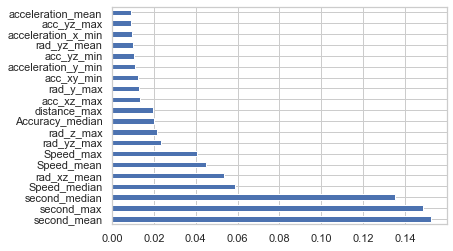

GradientBoostingClassifier
[3.00775075e-03 1.87326868e-02 4.11100213e-03 1.72267998e-03
 4.17296117e-03 2.22520136e-03 4.81169638e-03 3.84155311e-03
 4.70417320e-03 0.00000000e+00 7.62334698e-03 7.35943716e-03
 3.90301687e-03 4.60337948e-03 4.35209939e-03 8.23312243e-03
 1.20704603e-03 2.86548251e-03 3.29160168e-03 2.80417381e-03
 4.51704157e-04 2.49721633e-04 3.85309570e-04 1.34922765e-03
 4.03868256e-03 6.42471605e-04 3.37957889e-03 3.23233852e-03
 5.58167915e-03 1.52063394e-03 3.40765161e-03 3.52324287e-03
 1.50825692e-01 1.28909467e-01 1.49940793e-01 5.02116688e-02
 6.08014478e-02 4.77426511e-02 7.11833135e-04 6.78292025e-03
 7.87620841e-03 2.10058886e-02 2.53993383e-03 6.17989594e-03
 3.13754934e-03 2.93533562e-03 4.61435391e-03 2.15562056e-03
 1.49450892e-03 2.22253731e-03 1.14850508e-02 7.64770730e-03
 1.01640907e-03 1.35126247e-02 3.69598184e-03 9.89489396e-07
 1.29444134e-03 8.79907444e-03 1.28361606e-02 2.84115609e-03
 1.84206752e-03 1.13486545e-03 5.84058346e-04 7.48051645e-

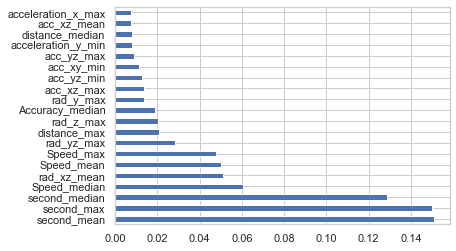

C:\Users\lyz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
[0.01114397 0.00696538 0.0057849  0.00281239 0.01170669 0.0107923
 0.00984561 0.00495243 0.01127599 0.01318169 0.01395611 0.01198421
 0.01066793 0.01184649 0.00983921 0.01229547 0.00931437 0.00941364
 0.01057546 0.00934669 0.00978644 0.0095547  0.01274634 0.0116725
 0.00994807 0.01050762 0.01005235 0.01186627 0.00915707 0.00892392
 0.01118767 0.01087906 0.03415996 0.01985043 0.03618799 0.01969403
 0.01615755 0.01961106 0.00374456 0.01536144 0.01314679 0.0213351
 0.00696895 0.01107739 0.00930052 0.01319448 0.01122647 0.00957068
 0.00873403 0.01167459 0.0091772  0.01031238 0.00924243 0.01168254
 0.01055756 0.00932228 0.01007225 0.01006613 0.01297624 0.01019935
 0.01092925 0.01129406 0.01203427 0.01226885 0.00949971 0.0121961
 0.01366828 0.01252917 0.0094416  0.01529803 0.01050738 0.01279607
 0.008412   0.01177003 0.00231253 0.01200947 0.01195152 0.01652586
 0.0021617  0.01184422 0.00967907 0.01642425 0.00227538 0.02011682
 0.01130202 0.01002641 0.00213862]


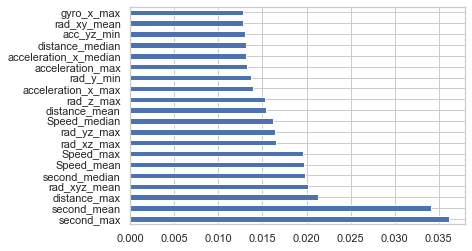

DecisionTreeClassifier
[0.02187189 0.00933161 0.00808768 0.00481832 0.0124184  0.0136934
 0.01115379 0.00846119 0.01515871 0.00940459 0.01442396 0.01708144
 0.00738323 0.00652935 0.01116048 0.00914162 0.00847867 0.00484813
 0.00684382 0.01239691 0.00626141 0.00779999 0.01024865 0.01288653
 0.01264331 0.01006069 0.01333495 0.01314228 0.01501971 0.01240557
 0.00916778 0.0117748  0.07663023 0.02127953 0.0406146  0.01611391
 0.02114294 0.03011438 0.00384015 0.01324416 0.01635786 0.01504918
 0.00762917 0.0111537  0.00802671 0.01388574 0.02162149 0.00443903
 0.00569015 0.00989029 0.01189046 0.00432715 0.00839428 0.01218211
 0.00845697 0.00858587 0.00864062 0.00448524 0.00984151 0.01003398
 0.01200294 0.01208148 0.00661274 0.01151224 0.01052894 0.00990186
 0.00729942 0.01106575 0.01047683 0.01827738 0.00724638 0.00738214
 0.00966548 0.01134805 0.00321725 0.01471923 0.0103835  0.01218893
 0.00236633 0.00723446 0.00863322 0.00746738 0.00071885 0.00380824
 0.00655974 0.0049606  0.00134638]


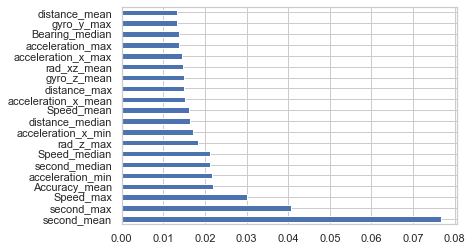

In [142]:
# This is the part where the data is split and fitting into the model. After the fitting, the importance the models
# place on the features are shown

predictors = ndata.drop(["bookingID", "label"], axis=1)
target = ndata["label"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.2, random_state = 0)

for name, clf in models_used.items():
    clf.fit(x_train, y_train)
    print(name)
    print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(clf.feature_importances_, index=predictors.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()

In [143]:
# Sorting the feature importance into a dataframe for each model

features_importance = pd.DataFrame()
clf_features_importance = pd.DataFrame()
for name, clf in models_used.items():
    feature_importance_map = {}
    for i in range(len(x_train.columns)):
        feature_importance_map[x_train.columns[i]] = clf.feature_importances_[i]
    sorted_feature_importance = dict(sorted(feature_importance_map.items(), key=itemgetter(1)))
    clf_features_importance[name] = list(sorted_feature_importance.keys())

#### Usually at this point of the notebook, preprocessing and hypertuning should be done to select the best amount of features to use, the configurations for each of the models, as well as the scoring. But I had too little time and decided to skip to the scoring

In [144]:
# select the top 10 features of each model
clf_features_importance[-10:]

,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,GradientBoostingClassifier,RandomForestClassifier,DecisionTreeClassifier
77,rad_z_max,acceleration_x_min,Accuracy_median,rad_z_max,Speed_median,distance_median
78,Speed_mean,distance_max,rad_z_max,distance_max,rad_yz_max,acceleration_x_min
79,Speed_median,distance_median,rad_yz_max,rad_yz_max,rad_xz_max,rad_z_max
80,distance_max,rad_xz_mean,Speed_max,Speed_max,Speed_max,Speed_median
81,acceleration_min,Speed_mean,Speed_mean,Speed_mean,Speed_mean,second_median
82,second_median,Speed_median,rad_xz_mean,rad_xz_mean,second_median,acceleration_min
83,Accuracy_mean,Speed_max,Speed_median,Speed_median,rad_xyz_mean,Accuracy_mean
84,Speed_max,second_median,second_median,second_median,distance_max,Speed_max
85,second_max,second_max,second_max,second_max,second_mean,second_max
86,second_mean,second_mean,second_mean,second_mean,second_max,second_mean


### Model Prediction

#### The Model with the best curve and accuracy is the Gradient Boosting Regressor

Model used: DecisionTreeRegressor
0.590311717482916


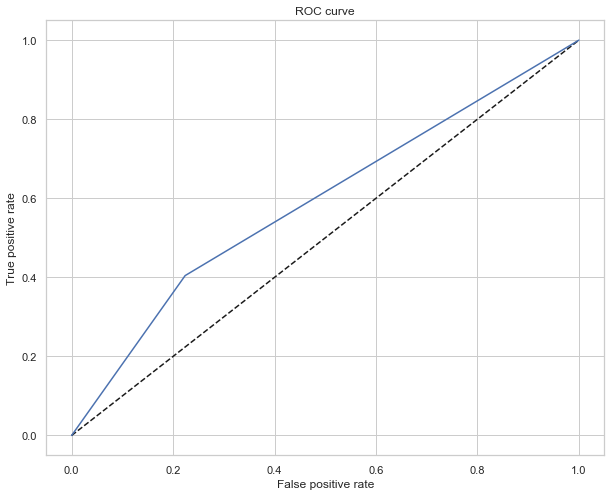

Model used: RandomForestRegressor
0.6695606368034962


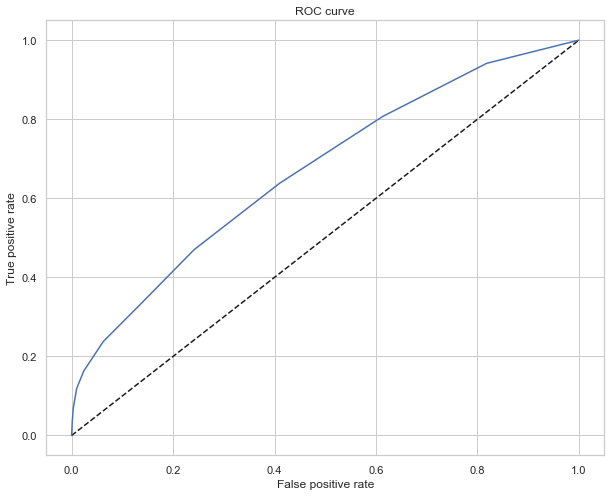

Model used: GradientBoostingRegressor
0.7095761429414837


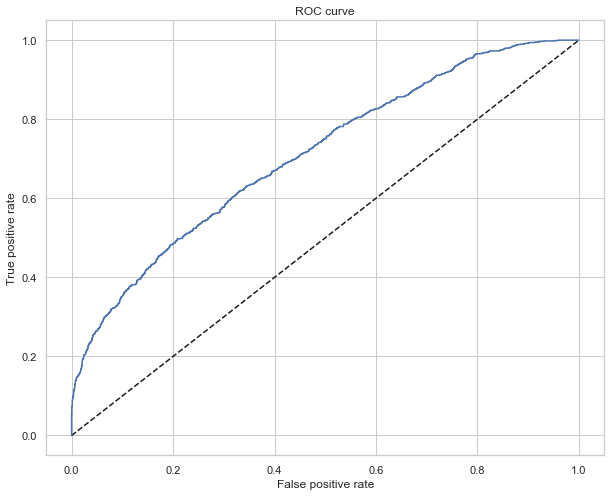

Model used: GradientBoostingClassifier
0.5912371658715672


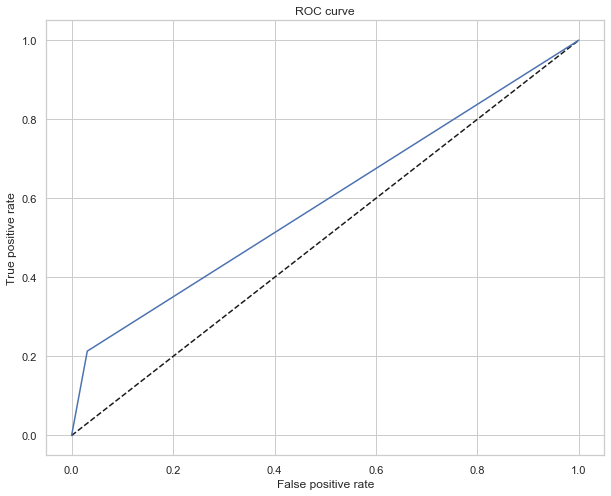

Model used: RandomForestClassifier
0.5899411988246551


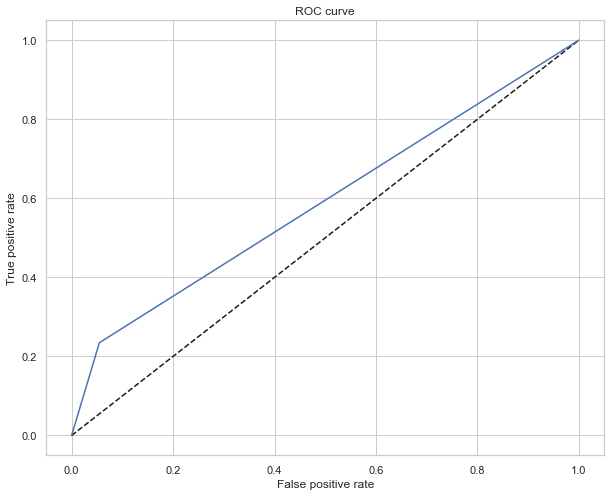

Model used: DecisionTreeClassifier
0.5877927334912222


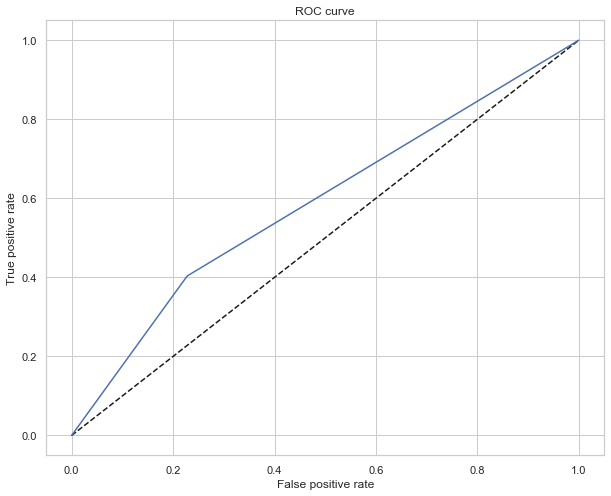

In [145]:
for name, clf in models_used.items():
    
    y_pred = clf.predict(x_val)
    print("Model used: "+name)
    print(roc_auc_score(y_val, y_pred))
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()

### Which feature has a high impact on indicating dangerous trips?
#### The feature with the highest impact is the average seconds

### How does the driving behaviour change over time (second) for normal trips and dangerous trips? What are the behaviour difference?
#### For drivers in dangerous trips, they are most likely to drive long trips which leads to higher chance of doing something dangerous. But for drivers of normal trips, they drive for a shorter amount of time which reduces the change they drive dangerously.

### Given the telematics data for new trips,  derive a model to detect if the trip is a dangerous trip.
#### The best model I could come up with is the Gradient Boosting Regressor